# Multi-class Refactoring Recommendation with SMOTE and Tree-based Algorithms
by Jerelyn Co (Jan 2018)

Main Reference: Kumar, L., & Sureka, A. (2017). Application of LSSVM and SMOTE on Seven Open Source Projects for Predicting Refactoring at Class Level. Asia-Pacific Software Engineering Conference (APSEC 2017), 90–99. https://doi.org/10.1109/APSEC.2017.15

In [1]:
import os

import numpy as np
import pandas as pd

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.model_selection import KFold,train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve

from collections import Counter


%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


### Classification Utils

In [2]:
TEST_SIZE = 0.3
RAND_STATE = 12
CV = 10

In [3]:
def get_inputs(data, features, label, binary_csf=True):
    if binary_csf:
        raw_X, y = data[features], data[label]
    else:
        # Label encoding for refactoring types. Transforming categorical labels to 0 to n_classes - 1.
        le = preprocessing.LabelEncoder()
        le.fit(data[label])
        data[label] = le.transform(data[label])
        raw_X, y = data[features], data[label]
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(raw_X)
    return X, y.values.ravel()

In [4]:
def metrics_report(true, pred):
    print('Model Report:')
    print(classification_report(true, pred))

    print("Accuracy Report:")
    print(accuracy_score(true, pred) * 100)
    print("-----\n")

In [32]:
def feature_importances(est, features):
    importances = est.feature_importances_
#     std = np.std([tree.feature_importances_ for tree in est.estimators_],
#                  axis=0)
    indices = np.argsort(importances)[::-1]

#     # Print the feature ranking
#     print("Feature ranking:")

#     for f in range(len(features)):
#         print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(features)), importances[indices],
           color="r", align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices])
    plt.xlim([-1, len(features)])
    plt.show()
    
    return [features[i] for i in indices]

In [6]:
def RF(X_train, y_train, X_test, y_test, tuning_params):
    clf_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuning_params, cv=CV)
    clf_rf.fit(X_train, y_train)

    print("Best parameters set found on development set: {}".format(clf_rf.best_params_))
    print("Grid scores on development set:")
    means = clf_rf.cv_results_['mean_test_score']
    stds = clf_rf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, clf_rf.predict(X_test)
    metrics_report(y_test, y_pred)
    
    return clf_rf.best_estimator_, y_true, y_pred

In [40]:
def XGB(X_train, y_train, X_test, y_test, param_test):
    clf_xgb = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=500, max_depth=8,
                                                           gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                           objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                             param_grid=param_test, scoring='roc_auc', iid=False, cv=CV)

    mod = clf_xgb.fit(X_train, y_train)
    y_true, y_pred = y_test, mod.predict(X_test)

    metrics_report(y_test, y_pred)
    return clf_xgb.best_estimator_, y_true, y_pred
    

In [8]:
def svc(X_train, y_train, X_test, y_test):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=CV)
    grid_search.fit(X, y)
    grid_search.best_params_
    metrics_report(y_test, est.predict(X_test))
    return grid_search.best_params_, grid_search.best_estimator_

In [9]:
def prc(est, X_test, y_test):
    precision, recall, _ = precision_recall_curve(y_test, est.predict_proba(X_test)[:,1])
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')

In [10]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

### Load Datasets

In [11]:
ant_dir = "data/raw/badsmells/data/apache-ant/apache-ant/"
xerces_dir = "data/raw/badsmells/data/apache-ant/xerces-j/"

ddata_dir = "data/transformed/"

In [59]:
data_df_csf = pd.read_csv(ddata_dir+"xerces.csv")
# Create a binary label column.
data_df_csf["w_ref"] = data_df_csf["Refactoring"].apply(lambda x: 0 if x =="not" else 1)
data_df_csf.head()

,Refactoring,Version_x,Class,NC,AG,NDC,ADD,DEL,CHURN,nsplit,...,RFC,CBO,LCOM,NOM,NOA,NOO,CCBC,C3,proj,w_ref
0,not,2.0.1,org.apache.xerces.dom.AttributeMap,1,69686388,3,140.0,59.0,14059.0,1,...,110,3,105,15,8,7,27.912213,0.401079,xerces2-j,0
1,not,2.0.1,org.apache.xerces.dom.AttributeMap,1,69686388,3,140.0,59.0,14059.0,1,...,110,3,105,15,8,7,27.816749,0.401079,xerces2-j,0
2,not,2.0.1,org.apache.xerces.dom.AttributeMap,1,69686388,3,140.0,59.0,14059.0,1,...,110,3,105,15,8,7,28.103010,0.401079,xerces2-j,0
3,not,2.0.1,org.apache.xerces.dom.AttributeMap,1,69686388,3,140.0,59.0,14059.0,1,...,113,3,105,15,8,7,28.474890,0.400960,xerces2-j,0
4,not,2.0.1,org.apache.xerces.dom.AttributeMap,1,69686388,3,140.0,59.0,14059.0,1,...,113,3,105,15,8,7,28.408250,0.402277,xerces2-j,0


In [60]:
info_cols = ['Version_x',  'Version_y', 'Class', 'nsplit']
bin_label = ['w_ref']
multi_label = ["Refactoring"]
proc_cols = ['AG', 'NDC', 'ADD', 'DEL', 'CHURN']
prod_cols = ['LOC', 'WMC', 'DIT', 'NOC', 'RFC','CBO', 'LCOM', 'NOM', 'NOA', 'NOO', 'CCBC', 'C3']

In [61]:
data_df_csf.dropna(inplace=True)
data_df_csf.drop_duplicates(inplace=True)

In [62]:
data_df_csf.groupby(["proj", "w_ref"])["Class"].count()

proj       w_ref
xerces2-j  0        53754
           1         1354
Name: Class, dtype: int64

## Binary Classification

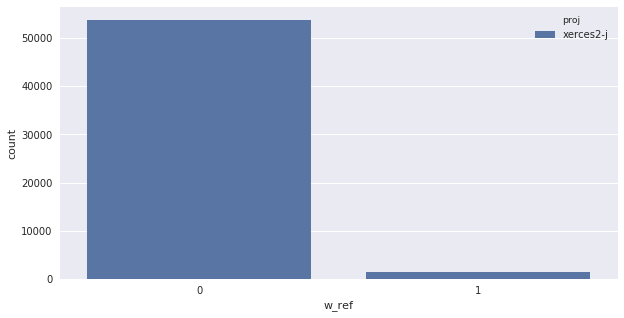

In [63]:
ax = sns.countplot(x="w_ref", data=data_df_csf, hue="proj")

Data is severely screwed to the negative class (without refactoring). 

Application of SMOTE to balance this severely screwed data may not be a good idea.

Try out cluster centroids.
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.ClusterCentroids.html

In [64]:
features = prod_cols + proc_cols
X, y = get_inputs(data_df_csf, features, bin_label)

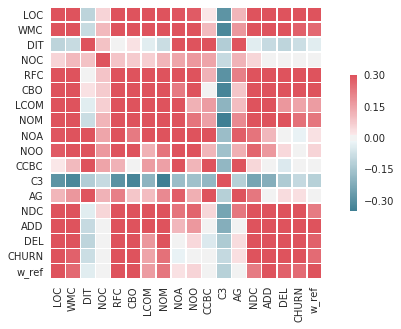

In [65]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_df_csf[features+bin_label].corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

### Using Random Forest

In [67]:
%%time
tuning_params = [{'n_estimators': [50, 100, 150, 300], 'max_features': [0.5,0.8]}]
est, y_true, y_pred = RF(X_train, y_train, X_test, y_test, tuning_params)

KeyboardInterrupt: 

### Using XGBoost

[Kaggle Introduction](https://www.kaggle.com/babatee/intro-xgboost-classification)

http://xgboost.readthedocs.io/en/latest//parameter.html

http://xgboost.readthedocs.io/en/latest//how_to/param_tuning.html

In [69]:
param_test = {
 'min_child_weight':[6,8,10,12]
}
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, param_test)

Model Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99     16132
          1       0.58      0.32      0.41       401

avg / total       0.97      0.98      0.97     16533

Accuracy Report:
97.7922941995
-----



Use of PRC 

Saito, T., & Rehmsmeier, M. (2015). The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PLoS ONE, 10(3), 1–21. https://doi.org/10.1371/journal.pone.011843

https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/

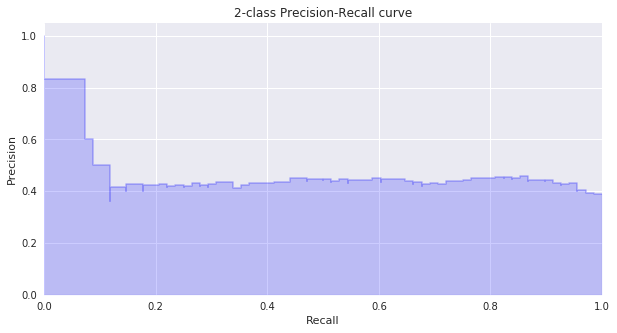

In [23]:
prc(est, X_test, y_test)

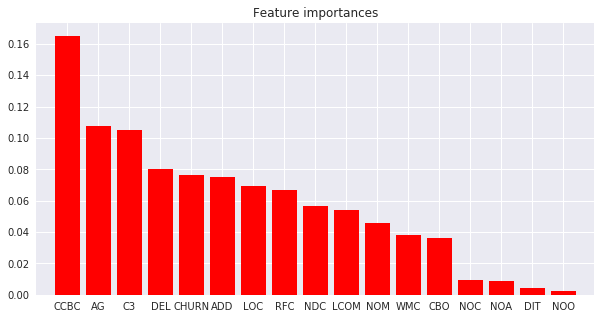

In [33]:
feature_ranking = feature_importances(est, features)

### Using SVC

In [ ]:
params, est = svc(X_train, y_train, X_test, y_test)

### Applying SMOTE to dataset. 
As we have seen during our data exploration, the dataset is severely imbalanced.

Reference: [Becker](https://www.google.co.jp/search?client=ubuntu&channel=fs&q=ROC+auc+curve+in+python&ie=utf-8&oe=utf-8&gfe_rd=cr&dcr=0&ei=EE1UWuPXNcyQ8QfT1YbAAw)

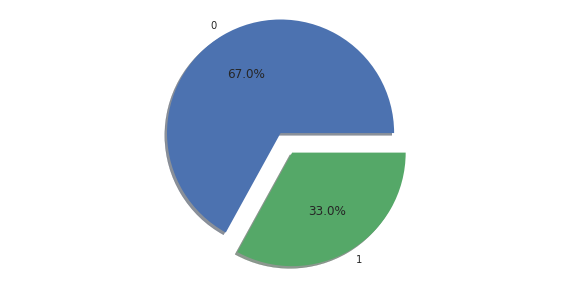

In [34]:
plot_pie(y_train)

In [35]:
sm = SMOTE(random_state=12, ratio=0.8)
X_train, y_train = sm.fit_sample(X_train, y_train)

/home/jerelyn/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


After SMOTE, we should see equal class distribution from synthetic samples generation.

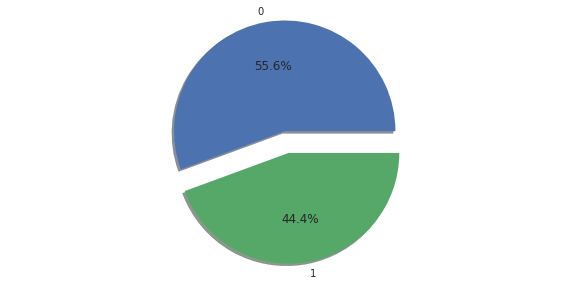

In [36]:
plot_pie(y_train)

Let's try again

In [ ]:
%%time
tuning_params = [{'n_estimators': [50, 100, 150, 300], 'max_features': [0.5,0.8]}]
est, y_true, y_pred = RF(X_train, y_train, X_test, y_test, tuning_params)

In [41]:
param_test = {
 'min_child_weight':[6,8,10,12]
}
XGB(X_train, y_train, X_test, y_test, param_test)

Model Report:
             precision    recall  f1-score   support

          0       0.61      0.62      0.61       110
          1       0.36      0.35      0.36        68

avg / total       0.51      0.52      0.52       178

Accuracy Report:
51.6853932584
-----



(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=8, min_child_weight=8, missing=None, n_estimators=500,
        n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
        subsample=0.8),
 array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]),
 array

In [ ]:
# Apply Cluster Centroids
cc = ClusterCentroids()
X_train_res, y_train_res = cc.fit_sample(X_train, y_train)

In [ ]:
np.bincount(y_train_res)

In [ ]:
param_test = {
 'min_child_weight':[6,8,10,12]
}
XGB(X_train_res, y_train_res, X_test, y_test, param_test)

In [ ]:
params, est = svc(X_train, y_train, X_test, y_test)

Let's try to reduce features by using the RF's built-in feature importances

In [56]:
top_features = [feature_ranking[0]]
# for i in feature_ranking[0]:
#     top_features.append(i)

Attempting feature reduction

In [57]:
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

In [ ]:
%%time
tuning_params = [{'n_estimators': [10, 20, 50, 100]}]
est, y_true, y_pred = RF(X_train, y_train.values.ravel(), X_test, y_test.values.ravel(), tuning_params)

In [58]:
param_test = {
 'min_child_weight':[6,8,10,12]
}
XGB(X_train, y_train, X_test, y_test, param_test)

Model Report:
             precision    recall  f1-score   support

          0       0.66      0.75      0.70       110
          1       0.47      0.37      0.41        68

avg / total       0.59      0.60      0.59       178

Accuracy Report:
60.1123595506
-----



(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=8, min_child_weight=6, missing=None, n_estimators=500,
        n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
        subsample=0.8),
 array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]),
 array

## What was done
- Multi-class prediction

## Preliminary Findings

- Despite the innate capability of tree-based algorithms to somehow compensate for unbalanced datasets, resampling has to be done in this specific application because of the severely unbalanced dataset. If we don't, then training would be problematic as there will be some classes that may be severely under-represented / zero.

## What else can be done

- Try out binary classification
- Hyperparameter tuning in XGBoost
- ROC AUC Curves
- Confusion Matrix
- Feature selection using the results of the algorithms' features significance
- Compare XGBoost's performance

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

# Apply Cluster Centroids
cc = ClusterCentroids()
X_res, y_res = cc.fit_sample(X, y)
X_res_vis = pca.transform(X_res)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

c0 = ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_res == 0, 0],
            X_res_vis[y_res == 0, 1],
            label="Class #0", alpha=.5)
ax2.scatter(X_res_vis[y_res == 1, 0],
            X_res_vis[y_res == 1, 1],
            label="Class #1", alpha=.5)
c2 = ax2.scatter(X_vis[y == 1, 0],
                 X_vis[y == 1, 1], label="Original #1",
                 alpha=0.2)
ax2.set_title('Cluster centroids with soft voting')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

plt.figlegend((c0, c1), ('Class #0', 'Class #1', 'Original Class #1'),
              loc='lower center',
              ncol=3, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()